In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from random import randint
from sklearn import tree
from skimage.feature import blob_doh, corner_peaks, hog
from skimage.io import imread, imsave
from skimage.morphology import watershed
from scipy import ndimage as ndi
from scipy.ndimage.measurements import label
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

%matplotlib inline

print('Success: Imported libraries.')

Success: Imported libraries.


## Extract HOG features from the training images.
### Read in all vehicle and non-vehicle images. Here are two example images, the first from the vehicle class and the second from the non-vehicle class:

img shape =  (64, 64, 3)


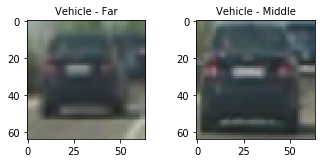

In [2]:
# Read in example images
img_vehicle_far = imread('vehicles/GTI_Far/image0000.png')
img_vehicle_middle = imread('vehicles/GTI_MiddleClose/image0000.png')


print('img shape = ', img_vehicle_far.shape)
train_height = img_vehicle_far.shape[0]
train_width = img_vehicle_far.shape[1]
train_channels = img_vehicle_far.shape[2]

# Display
f1, (a11, a12) = plt.subplots(1, 2, figsize=(4, 3))
f1.tight_layout()
a11.imshow(img_vehicle_far)
a11.set_title('Vehicle - Far', fontsize=10)
a12.imshow(img_vehicle_middle)
a12.set_title('Vehicle - Middle', fontsize=10)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

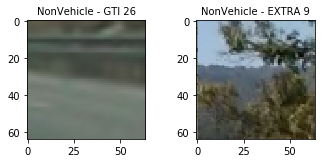

In [3]:
img_nonVehicle_gti26 = imread('non-vehicles/GTI/image26.png')
img_nonVehicle_extra9 = imread('non-vehicles/Extras/extra9.png')

# Display
f1, (a11, a12) = plt.subplots(1, 2, figsize=(4, 3))
f1.tight_layout()
a11.imshow(img_nonVehicle_gti26)
a11.set_title('NonVehicle - GTI 26', fontsize=10)
a12.imshow(img_nonVehicle_extra9)
a12.set_title('NonVehicle - EXTRA 9', fontsize=10)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Extract HOG features and HOG visualisation.

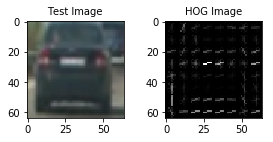

In [4]:
def get_hog_features(img_, orient_, pix_per_cell_, cell_per_block_, vis_=False):
    # Call with two outputs if vis==True
    if vis_ == True:
        features, hog_image = hog(img_, orientations=orient_, pixels_per_cell=(pix_per_cell_, pix_per_cell_),
                                  cells_per_block=(cell_per_block_, cell_per_block_), transform_sqrt=True, 
                                  visualise=vis_, feature_vector=True)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img_, orientations=orient_, pixels_per_cell=(pix_per_cell_, pix_per_cell_),
                       cells_per_block=(cell_per_block_, cell_per_block_), transform_sqrt=True, 
                       visualise=vis_, feature_vector=True)
        return features


'''
test it...
'''
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2
ORIENT = 9

hog_test_img = imread('vehicles/GTI_MiddleClose/image0001.png')
hog_test_gray = cv2.cvtColor(hog_test_img, cv2.COLOR_RGB2GRAY)
features, hog_test_result = get_hog_features(hog_test_gray, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, vis_=True)

# Display
f1, (a11, a12) = plt.subplots(1, 2, figsize=(4, 3))
f1.tight_layout()
a11.imshow(hog_test_img)
a11.set_title('Test Image', fontsize=10)
a12.imshow(hog_test_result, cmap='gray')
a12.set_title('HOG Image', fontsize=10)

In [5]:

def add_filenames_to_list(list_, filenames_):
    for filename in filenames_:
        list_.append(filename)

# Vehicles
car_filepaths = []
car_directories = ['vehicles/GTI_Far/',
                   'vehicles/GTI_Left/',
                   'vehicles/GTI_MiddleClose/',
                   'vehicles/GTI_Right/',
                   'vehicles/KITTI_extracted/']
for folder in car_directories:
    glob_filenames = glob.glob(folder + '*.png')
    add_filenames_to_list(car_filepaths, glob_filenames)


# Non-Vehicles
notcar_filepaths = []
notcar_directories = ['non-vehicles/GTI/',
                      'non-vehicles/Extras/']
for folder in notcar_directories:
    glob_filenames = glob.glob(folder + '*.png')
    add_filenames_to_list(notcar_filepaths, glob_filenames)


print('Car Samples = {}'.format(len(car_filepaths)))
print('Non-car Samples = {}'.format(len(notcar_filepaths)))
print('Success: Created image name lists.')

Car Samples = 8792
Non-car Samples = 8968
Success: Created image name lists.


In [6]:
# Define a function to extract features from a list of images
#   uses Lab color space and only hog features
def extract_features(img_, spatial_size_=(32, 32),
                           hist_bins_=32, hist_range_=(0, 256), orient_=9, 
                           pix_per_cell_=8, cell_per_block_=2):
    # apply color conversion
    img_lab = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab) 
    # create feature vectors
    hog_features_0 = get_hog_features(img_lab[:,:,0], orient_, 
            pix_per_cell_, cell_per_block_, vis_=False)
    hog_features_1 = get_hog_features(img_lab[:,:,1], orient_, 
            pix_per_cell_, cell_per_block_, vis_=False)
    hog_features_2 = get_hog_features(img_lab[:,:,2], orient_, 
            pix_per_cell_, cell_per_block_, vis_=False)
    # concat features
    return np.concatenate((hog_features_0, hog_features_1, hog_features_2))


# Define a function to extract features from a list of images
def extract_features_files(filepaths_, spatial_size_=(32, 32),
                           hist_bins_=32, hist_range_=(0, 256), orient_=9, 
                           pix_per_cell_=8, cell_per_block_=2):
    features_list = []   #list to append feature vectors to
    for filepath in filepaths_:
        image = imread(filepath)
        #image = image.astype(np.float32)
        features_single = extract_features(image, spatial_size_,
                           hist_bins_, hist_range_, orient_, 
                           pix_per_cell_, cell_per_block_)
        
        if np.isnan(features_single).any():
            print(filepath)
        
        features_list.append(features_single)
    return features_list

#### Find features

In [7]:
print('Extracting car features...')
car_features = extract_features_files(car_filepaths, orient_=ORIENT, 
                                      pix_per_cell_=PIX_PER_CELL, 
                                      cell_per_block_=CELL_PER_BLOCK)
print('Extracting non-car features...')
notcar_features = extract_features_files(notcar_filepaths, orient_=ORIENT, 
                                         pix_per_cell_=PIX_PER_CELL, 
                                         cell_per_block_=CELL_PER_BLOCK)
print('Features found.')

Extracting car features...
Extracting non-car features...
Features found.


In [8]:
def preprocess_features(car_features_, notcar_features_):    
    # Create an array stack of feature vectors
    X = np.vstack((car_features_, notcar_features_)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Get mean=0 and variance=1
    return X_scaler.transform(X), X_scaler

# Define the labels vector
def create_labels(car_features_, notcar_features_):
    return np.hstack((np.ones(len(car_features_)), np.zeros(len(notcar_features_))))

In [9]:
scaled_features, data_scaler = preprocess_features(car_features, notcar_features)
total_labels = create_labels(car_features, notcar_features)

print('scaled_features.shape = ', scaled_features.shape)
print('total_labels.shape = ', total_labels.shape)

scaled_features.shape =  (17760, 5292)
total_labels.shape =  (17760,)


In [10]:
# Split up data into randomized training and test sets
def split_test_and_train(X_, Y_, test_size_=0.2):
    start_rand = np.random.randint(0, 100)
    X_train, X_test, Y_train, Y_test = \
      train_test_split(X_, Y_, test_size=test_size_, random_state=start_rand)
    return (X_train, X_test, Y_train, Y_test)

# Calibrated Linear Support-Vector-Classifier
def train_svc(X_train_, X_test_, Y_train_, Y_test_, c_=1.0):
    # setup linear support-vector-classifier
    svc = LinearSVC(C=c_)
    # setup and train calibrated classifier
    cal_svc = CalibratedClassifierCV(svc)
    cal_svc.fit(X_train_, Y_train_)
    # Check the score of the classifier
    print('Train Accuracy of SVC = ', cal_svc.score(X_train_, Y_train_))
    print('Test Accuracy of SVC = ', cal_svc.score(X_test_, Y_test_))
    return cal_svc

In [11]:
x_train, x_test, y_train, y_test = \
  split_test_and_train(scaled_features, total_labels)
print('Split data.')
trained_svc = train_svc(x_train, x_test, y_train, y_test, 1000.0)
print('Trained SVC.')

Split data.
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.987894144144
Trained SVC.


## Find Cars

In [12]:
def draw_boxes(img_, bboxes_, color_=(0, 0, 255), thick_=6):
    img_copy = np.copy(img_)
    # Iterate through the bounding boxes
    for bbox in bboxes_:
        cv2.rectangle(img_copy, bbox[0], bbox[1], color_, thick_)
    return img_copy

# Define a function that takes an image,
#   start and stop positions in both x and y, 
#   window size (x and y dimensions),  
#   and overlap fraction (for both x and y)
def slide_window(img_, x_start_stop_=[None, None], y_start_stop_=[None, None], 
                    xy_window_=(64, 64), xy_overlap_=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop_[0] == None:
        x_start_stop_[0] = 0
    if x_start_stop_[1] == None:
        x_start_stop_[1] = img_.shape[1]
    if y_start_stop_[0] == None:
        y_start_stop_[0] = 0
    if y_start_stop_[1] == None:
        y_start_stop_[1] = img_.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop_[1] - x_start_stop_[0]
    yspan = y_start_stop_[1] - y_start_stop_[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window_[0]*(1 - xy_overlap_[0]))
    ny_pix_per_step = np.int(xy_window_[1]*(1 - xy_overlap_[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop_[0]
            endx = startx + xy_window_[0]
            starty = ys*ny_pix_per_step + y_start_stop_[0]
            endy = starty + xy_window_[1]
            # window limits
            startx = 0 if startx < 0 else startx
            endx = img_.shape[1] if endx > img_.shape[1] else endx
            starty = 0 if starty < 0 else starty
            endy = img_.shape[0] if endy > img_.shape[0] else endy
            # Append window position to list
            if (endx-startx == xy_window_[0]) and (endy-starty == xy_window_[1]):
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


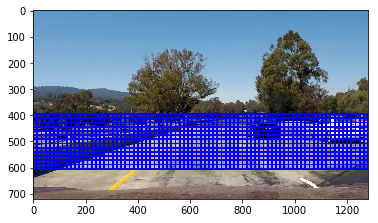

In [13]:
TEST_IMG = imread('test_images/test1.jpg')
WINDOW_SIZE = (64,64) #(128,128)
OVERLAP = (0.75,0.75)
Y_START_STOP = [int(TEST_IMG.shape[0]*0.55), int(TEST_IMG.shape[0]*0.8)]
test_windows = slide_window(TEST_IMG, 
                            x_start_stop_=[None, None], y_start_stop_=Y_START_STOP, 
                            xy_window_=WINDOW_SIZE, xy_overlap_=OVERLAP)
img_windows = draw_boxes(TEST_IMG, test_windows, color_=(0, 0, 255), thick_=6)
plt.imshow(img_windows)

In [14]:
def find_cars(img_, window_list_, window_size_, scaler_, classifier_):
    img_window = np.zeros(window_size_)
    num_detections = 0
    window_list_detections = []
    # for each window...
    for bbox in window_list_:
        # extract part of img_
        top_L_x = bbox[0][0]
        top_L_y = bbox[0][1]
        bot_R_x = bbox[1][0]
        bot_R_y = bbox[1][1]
        img_window = img_[top_L_y:bot_R_y,top_L_x:bot_R_x,:]
        # resize to 64x64
        img_resized = cv2.resize(img_window, (train_height,train_width))
        # extract features
        features = extract_features(img_resized, orient_=ORIENT, 
                                    pix_per_cell_=PIX_PER_CELL, cell_per_block_=CELL_PER_BLOCK)
        features = features.reshape(1, -1)   #stop the executor from complaining
        # preprocess features
        scaled_features = scaler_.transform(features)
        # predict with svc
        prediction = classifier_.predict(scaled_features)
        prediction_prob_1 = classifier_.predict_proba(scaled_features)[0][1]
        if prediction == 1 and prediction_prob_1 > 0.75:
            window_list_detections.append(bbox)
            num_detections += 1

    #print('{} detections.'.format(num_detections))
    return window_list_detections

# map the inputs to the function blocks
color_dict = {0: (255,   0,   0),  #red
              1: (  0, 255,   0),  #green
              2: (  0,   0, 255),  #blue
              3: (255, 255,   0),  #yellow
              4: (255,   0, 255),  #purple
              5: (255, 140,   0)   #orange
}

def draw_detections(img_, detections_list_, draw_color_=None):
    if draw_color_ is None:
        draw_color_ = color_dict[randint(0,5)]
    return draw_boxes(img_, detections_list_, color_=draw_color_)


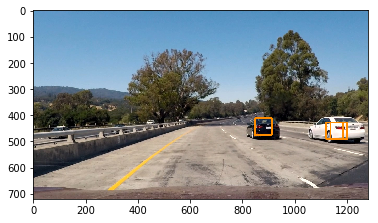

In [15]:
detections_list = find_cars(TEST_IMG, test_windows, WINDOW_SIZE, data_scaler, trained_svc)
img_boxed_cars = draw_detections(TEST_IMG, detections_list)
plt.imshow(img_boxed_cars)

In [16]:
# find cars with different size windows
def find_cars_multiSize(img_, window_sizes_, overlaps_, startStops_, scaler_, classifier_):
    detections_list_total = []
    #for size in window_sizes_:
    for size, overlap, start_stop in zip(window_sizes_, overlaps_, startStops_):
        windows = slide_window(img_, x_start_stop_=[None, None], y_start_stop_=start_stop, 
                               xy_window_=size, xy_overlap_=overlap)
        detections_list = find_cars(img_, windows, size, scaler_, classifier_)
        detections_list_total = detections_list_total + detections_list
    return detections_list_total

def findAndDraw_cars_multiSize(img_, window_sizes_, overlaps_, startStops_, scaler_, classifier_):
    detections = find_cars_multiSize(img_, window_sizes_, overlaps_, startStops_, scaler_, classifier_)
    return draw_detections(np.copy(img_), detections)   

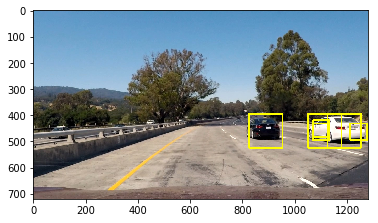

In [17]:
TEST_IMG = imread('test_images/test1.jpg')
WINDOW_SIZES_MULTI = [(64,64),(128,128)]
#OVERLAP_MULTI = [(0.65,0.65),(0.75,0.75)]
OVERLAP_MULTI = [(0.8,0.8),(0.8,0.8)]
START_STOP_MULTI = [[int(TEST_IMG.shape[0]*0.55), int(TEST_IMG.shape[0]*0.8)],
                    [int(TEST_IMG.shape[0]*0.55),None]]
img_detect_cars = findAndDraw_cars_multiSize(TEST_IMG, WINDOW_SIZES_MULTI, OVERLAP_MULTI, 
                                             START_STOP_MULTI, data_scaler, trained_svc)
plt.imshow(img_detect_cars)

In [18]:

def detect_on_test_images(img_names_, window_sizes_, overlaps_, startStops_, scaler_, classifier_):
    is_left = True
    for index, name in enumerate(img_names_):
        print(name)
        image = imread('test_images/' + name)
    
        image = findAndDraw_cars_multiSize(image, window_sizes_, overlaps_, startStops_, scaler_, classifier_)
    
        if is_left:
            fig = plt.figure(figsize=(8, 6))
            a=fig.add_subplot(1,2,1)
            is_left = False
        else:    
            a=fig.add_subplot(1,2,2)
            is_left = True
        a.set_title(name)
        plt.imshow(image)

test1.jpg
test2.jpg
test3.jpg
test4.jpg
test5.jpg
test6.jpg


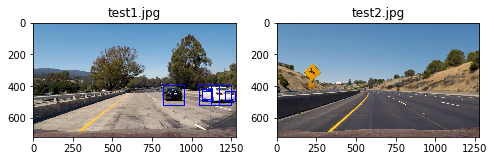

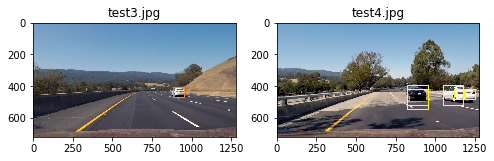

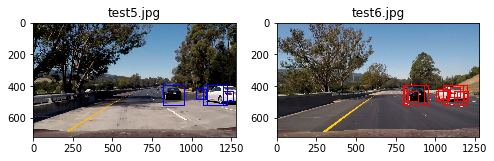

In [19]:
IMG_NAMES = os.listdir('test_images/')
detect_on_test_images(IMG_NAMES, WINDOW_SIZES_MULTI, OVERLAP_MULTI, START_STOP_MULTI, data_scaler, trained_svc)

In [20]:
TEST_IMG = imread('test_images/test6.jpg')

### Creating Heat Maps

In [21]:
def add_heat(heatmap_, bbox_list_):
    # Iterate through list of bboxes
    for box in bbox_list_:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap_[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap_

def apply_threshold(heatmap_, threshold_):
    # Zero out pixels below the threshold
    heatmap_[heatmap_ < threshold_] = 0
    heatmap_[heatmap_ > 0] = 1
    return heatmap_

def bbox_from_labels(labels_):
    bbox_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels_[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels_[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)        
    return bbox_list

def bboxes_from_detections(img_, detections_, threshold_):
    heatmap = np.zeros((img_.shape[0],img_.shape[1]))
    heatmap = add_heat(heatmap, detections_)
    heatmap = apply_threshold(heatmap, threshold_)
    labels = label(heatmap)
    return bbox_from_labels(labels) 


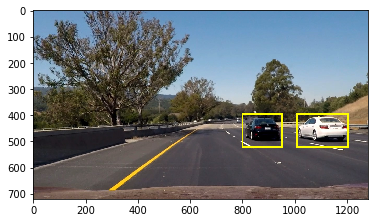

In [22]:
detections_for_heatmap = find_cars_multiSize(TEST_IMG, WINDOW_SIZES_MULTI, OVERLAP_MULTI, 
                                             START_STOP_MULTI, data_scaler, trained_svc)
combined_boxes = bboxes_from_detections(TEST_IMG, detections_for_heatmap, 1)
img_combined_box = draw_detections(TEST_IMG, combined_boxes)
plt.imshow(img_combined_box)

In [23]:
def bound_test_images(img_names_, window_sizes_, overlap_, startStops_, scaler_, classifier_):
    is_left = True
    for index, name in enumerate(img_names_):
        print(name)
        image = imread('test_images/' + name)
        
        detections = find_cars_multiSize(image, window_sizes_, overlap_, startStops_, scaler_, classifier_)
        if len(detections) != 0:
            combined_boxes = bboxes_from_detections(TEST_IMG, detections, 1)
            image = draw_detections(image, combined_boxes)

        # display
        if is_left:
            fig = plt.figure(figsize=(8, 6))
            a=fig.add_subplot(1,2,1)
            is_left = False
        else:    
            a=fig.add_subplot(1,2,2)
            is_left = True
        a.set_title(name)
        plt.imshow(image)
        

test1.jpg
test2.jpg
test3.jpg
test4.jpg
test5.jpg
test6.jpg


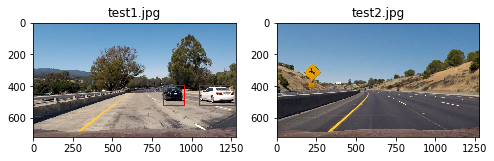

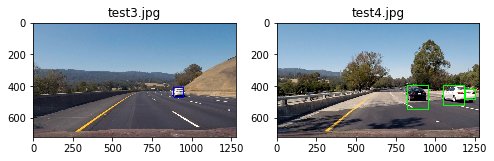

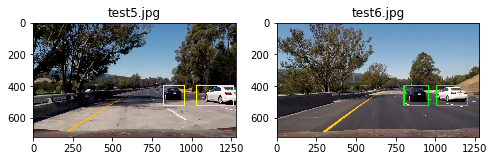

In [24]:
IMG_NAMES = os.listdir('test_images/')
bound_test_images(IMG_NAMES, WINDOW_SIZES_MULTI, OVERLAP_MULTI, START_STOP_MULTI, data_scaler, trained_svc)

## Generate video

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def grab_video_frame(filepath_, frame_):
    clip = VideoFileClip(filepath_)
    return clip.get_frame(frame_)

# image should be RGB
def save_image(img_, filepath_):
    mpimg.imsave(filepath_, img_)




Success: Defined functions to grab video frames.


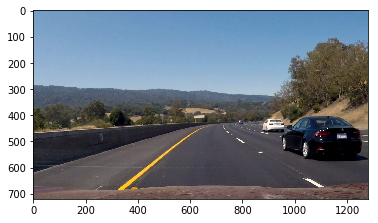

In [26]:
frame_num = 30
test_frame = grab_video_frame('project_video.mp4', frame_num)
plt.imshow(test_frame)


print('Success: Defined functions to grab video frames.')

In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
class VideoProcessor:
    def __init__(self):
        self._frame_index = 0
        self._FRAME_AGGREGATE = 10
        self._detection_list_total = None
        self._bbox_list_recent = None
        self._threshold = 2
    
    def _aggregate_detections(self, detections_):
        if self._detection_list_total is None:
            self._detection_list_total = detections_
        else:
            self._detection_list_total.extend(detections_)

    #External API
    def process_image(self, image_):
        # find detections
        detections = find_cars_multiSize(image_, WINDOW_SIZES_MULTI, OVERLAP_MULTI, 
                                     START_STOP_MULTI, data_scaler, trained_svc)
        
        # aggregate detections
        self._aggregate_detections(detections)
        
        # increment frame number
        self._frame_index += 1
        
        # if we have enough frames...
        if self._frame_index%self._FRAME_AGGREGATE == 0:
            # get aggregate bboxes
            self._bbox_list_recent = bboxes_from_detections(image_, self._detection_list_total,
                                                            self._threshold)
            # reset the detections
            self._detection_list_total = None   #reset system

        # if we have bboxes... 
        if self._bbox_list_recent is not None:
            # draw them
            image_ = draw_detections(image_, self._bbox_list_recent, (0,0,255))
        
        return image_


In [ ]:
def process_video(input_filename_, output_filename_, subclip_=None):
    # Grab the video
    if subclip_ is None:
        clip = VideoFileClip(input_filename_)
    else: 
        clip = VideoFileClip(input_filename_).subclip(subclip_[0],subclip_[1])
    
    # Process the frames
    video_processor = VideoProcessor()
    
    processed_clip = clip.fl_image(video_processor.process_image)

    # Save the video
    %time processed_clip.write_videofile(output_filename_, audio=False)

In [ ]:
import io
import base64
process_video('project_video.mp4', 'project_video_soln.mp4')
video = io.open('project_video_soln.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

[MoviePy] >>>> Building video project_video_soln.mp4
[MoviePy] Writing video project_video_soln.mp4


 32%|███▏      | 399/1261 [46:10<1:34:57,  6.61s/it]